In [1]:
#import all necessary libaries

from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

In [2]:
#define all input files

train_dataset_fp = "./training/train_dataset.csv"
manifest_file = "./manifest.json"

In [3]:
column_names = ['humidity', 'temperature', 'pm2_5', 'pm10', 'asthmatic_level',
                'predicted_comfort_level']

feature_names = column_names[:-1]
label_name = column_names[-1]

comfort_level_desc = ['Very Good', 'Ok', 'Uncomfortable', 'Very Uncomfortable', 'Hazardous']

#print(comfort_level_desc)
#print("Features: {}".format(feature_names))
#print("Label: {}".format(label_name))

In [4]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size, 
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [5]:
# features, labels = next(iter(train_dataset))

In [6]:
#for inspecting data
#the graph should display a relationship for humidity and temperature data
#due to the data being generated by random values, it might not show correlations
#would be better to find actual reading for these features

# plt.scatter(features['humidity'],
#             features['temperature'],
#             c=labels,
#             cmap='viridis')

# plt.xlabel("humidity")
# plt.ylabel("temperature");

In [7]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [8]:
train_dataset = train_dataset.map(pack_features_vector)

In [9]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[0.59 0.14 0.82 1.61 0.2 ]
 [0.14 0.77 2.29 2.6  0.4 ]
 [0.52 0.25 1.41 2.47 0.2 ]
 [0.67 0.78 1.84 3.68 0.1 ]
 [0.13 0.75 1.76 3.17 0.4 ]], shape=(5, 5), dtype=float32)


In [10]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(5,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(5)
])

In [11]:
# predictions = model(features)
# predictions[:5]

In [12]:
# tf.nn.softmax(predictions[:5])

In [13]:
# print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
# print("    Labels: {}".format(labels))

In [14]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 2.8008995056152344


In [15]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [16]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.train.get_or_create_global_step()

In [17]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 2.8008995056152344
Step: 1,         Loss: 2.6564741134643555


In [18]:
## Note: Rerunning this cell uses the same model variables

checkpoint_directory = "./model/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
#status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_directory))

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

checkpoint.save(file_prefix=checkpoint_prefix)

Epoch 000: Loss: 1.768, Accuracy: 20.020%
Epoch 050: Loss: 0.836, Accuracy: 65.365%
Epoch 100: Loss: 0.720, Accuracy: 69.169%
Epoch 150: Loss: 0.651, Accuracy: 72.673%
Epoch 200: Loss: 0.566, Accuracy: 77.578%


'./model/training_checkpoints\\ckpt-1'

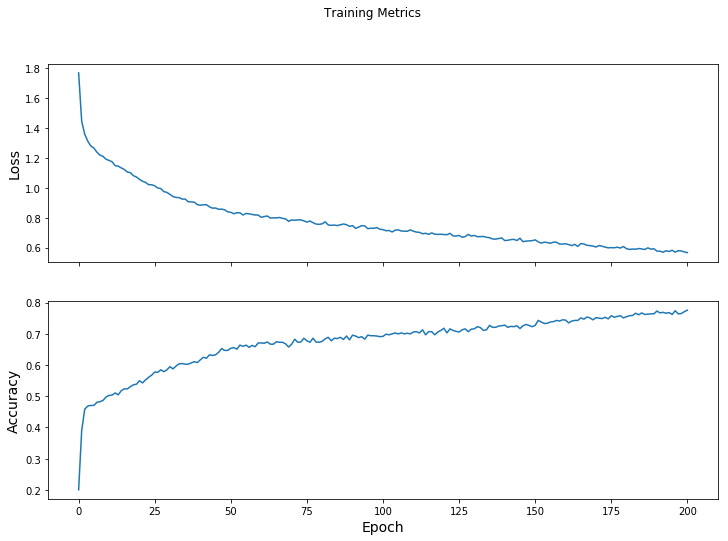

In [19]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);